<a href="https://colab.research.google.com/github/yihui98/ImageAI---Cops/blob/master/TayYiHuiCopsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for determining the nature of actions (Good/Bad) in the context of cops.

After seeing the state of unrest around the world, I've decided to try and create a model which can determine the nature of actions executed by cops. For us, it is intuitive when cops behave badly, so I thought it would be interesting to see it from a machine point of view.

In [ ]:
%matplotlib inline

import os
import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout, Flatten,Input,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from glob import glob
from tensorflow.keras.preprocessing import image



In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

!wget https://www.dropbox.com/sh/raw/3uwqwxx5qv10ibd/AAC3h10JYzZoper-hNjS4oOHa


--2020-06-05 08:02:06--  https://www.dropbox.com/sh/raw/3uwqwxx5qv10ibd/AAC3h10JYzZoper-hNjS4oOHa
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0072336370b613d1833f51a7fa.dl.dropboxusercontent.com/zip_download_get/Acf-mWAlxF3yZO20ko-4GSvyoJuC_2lOU9VR9XIqDR_39SxKv4YKP-n7Fwj3atxvbPaFRpRrpEg7f_TQX9Qx6tV9KlPncxCepm5Orvgak5YJYg [following]
--2020-06-05 08:02:09--  https://uc0072336370b613d1833f51a7fa.dl.dropboxusercontent.com/zip_download_get/Acf-mWAlxF3yZO20ko-4GSvyoJuC_2lOU9VR9XIqDR_39SxKv4YKP-n7Fwj3atxvbPaFRpRrpEg7f_TQX9Qx6tV9KlPncxCepm5Orvgak5YJYg
Resolving uc0072336370b613d1833f51a7fa.dl.dropboxusercontent.com (uc0072336370b613d1833f51a7fa.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to uc0072336370b613d1833f51a7fa.dl.dropboxusercontent.com (uc0072336370b613d

In [ ]:
!unzip AAC3h10JYzZoper-hNjS4oOHa -x /


Archive:  AAC3h10JYzZoper-hNjS4oOHa
replace Bad cops/Z.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls 'Bad cops'


'2Q__ (10).jpg'  '9k_ (1).jpg'	    'images (24).jpg'  'images (8).jpg'
'2Q__ (11).jpg'  '9k_ (20).jpg'     'images (25).jpg'  'images (9).jpg'
'2Q__ (12).jpg'  '9k_ (21).jpg'     'images (27).jpg'  'Z (11).jpg'
'2Q__ (13).jpg'  '9k_ (22).jpg'     'images (28).jpg'  'Z (12).jpg'
'2Q__ (14).jpg'  '9k_ (2).jpg'	    'images (29).jpg'  'Z (13).jpg'
'2Q__ (15).jpg'  '9k_ (3).jpg'	    'images (2).jpg'   'Z (14).jpg'
'2Q__ (1).jpg'	 '9k_ (4).jpg'	    'images (30).jpg'  'Z (15).jpg'
'2Q__ (2).jpg'	 '9k_ (7).jpg'	    'images (31).jpg'  'Z (17).jpg'
'2Q__ (3).jpg'	 '9k_ (8).jpg'	    'images (32).jpg'  'Z (18).jpg'
'2Q__ (4).jpg'	 '9k_ (9).jpg'	    'images (33).jpg'  'Z (19).jpg'
'2Q__ (6).jpg'	  9k_.jpg	    'images (34).jpg'  'Z (1).jpg'
'2Q__ (7).jpg'	 'images (10).jpg'  'images (35).jpg'  'Z (20).jpg'
'2Q__ (8).jpg'	 'images (11).jpg'  'images (37).jpg'  'Z (21).jpg'
'2Q__ (9).jpg'	 'images (12).jpg'  'images (38).jpg'  'Z (22).jpg'
 2Q__.jpg	 'images (13).jpg'  'images (39).jpg'  'Z (23).jpg'


In [ ]:
batch_size = 10
epochs = 10
lr = 0.001

Converting raw files into data

In [ ]:
paths = ['Good cops', 'Bad cops']

data = []
for path in paths:
  for root, dirs, files in os.walk(path, topdown=True):
    for name in files:
      if '.jpg' not in name:
        continue
      filename = os.path.abspath(os.path.join(root, name))
      class_name = os.path.basename(root)
      data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
df.dtypes

                                         filename class_name  class
0  /content/Good cops/cool-police-officers-16.jpg  Good cops      1
1              /content/Good cops/images (27).jpg  Good cops      1
2              /content/Good cops/images (36).jpg  Good cops      1
3               /content/Bad cops/images (21).jpg   Bad cops      0
4                    /content/Good cops/Z (3).jpg  Good cops      1


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
len(df)

187

In [ ]:
# Split into train and validation sets
train_set_percentage = .83

df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(10)
print(df.shape)
print(df_val.shape)

df['class'].unique()

(155, 3)
(27, 3)


array([0, 1], dtype=int8)

Pipeline for loading and resizing images


In [ ]:
img_width, img_height = 300,300
num_classes = 2

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_width, img_height])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset= train_dataset.map(_parse_function)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32, drop_remainder = True)

train_dataset

<BatchDataset shapes: ((32, 300, 300, 3), (32, 2)), types: (tf.float32, tf.float32)>

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
valid_dataset = valid_dataset.batch(32)


Importing of Model


In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (300,300,3), pooling = None)

In [ ]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)


In [ ]:
for layer in base_model.layers:
  layer_trainable = False

In [ ]:

opt = tf.keras.optimizers.Adam()
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
train_steps = int(15)
val_steps = int(1)

history = model.fit(train_dataset,steps_per_epoch = train_steps, epochs = epochs, validation_data = valid_dataset, validation_steps= val_steps)


Epoch 1/10
15/15 [==============================] - 22s 1s/step - loss: 0.9363 - accuracy: 0.5188 - val_loss: 0.6888 - val_accuracy: 0.5556
Epoch 2/10
15/15 [==============================] - 22s 1s/step - loss: 0.6985 - accuracy: 0.4896 - val_loss: 0.6913 - val_accuracy: 0.5556
Epoch 3/10
15/15 [==============================] - 22s 1s/step - loss: 0.7112 - accuracy: 0.5354 - val_loss: 0.6883 - val_accuracy: 0.5556
Epoch 4/10
15/15 [==============================] - 22s 1s/step - loss: 0.6931 - accuracy: 0.5104 - val_loss: 0.6889 - val_accuracy: 0.5556
Epoch 5/10
15/15 [==============================] - 22s 1s/step - loss: 0.6901 - accuracy: 0.5417 - val_loss: 0.6887 - val_accuracy: 0.5556
Epoch 6/10
15/15 [==============================] - 22s 1s/step - loss: 0.6932 - accuracy: 0.5208 - val_loss: 0.6892 - val_accuracy: 0.5556
Epoch 7/10
15/15 [==============================] - 22s 1s/step - loss: 0.6905 - accuracy: 0.5333 - val_loss: 0.6900 - val_accuracy: 0.5556
Epoch 8/10
15/15 [==

Ok, so this code is an absolute failure, so I did that the exact same thing, but used a different model and ReduceLROnPlateau and the results are too good to be true. It might be due to the huge increase in depth.

In [ ]:

second_model = tf.keras.applications.Xception(weights = 'imagenet', include_top = False, input_shape = (300,300,3), pooling = None)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
x = second_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation = 'softmax')(x)
model_2 = Model(inputs = second_model.input, outputs = predictions)

In [ ]:
for layer in second_model.layers:
  layer_trainable = False

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoints/best_weights.hdf5', monitor = 'val_accuracy', verbose= 1, save_best_only= True, mode= 'auto')
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.8, patience = 1, cooldown = 0, min_lr = 0.00001)

In [ ]:
opt = tf.keras.optimizers.Adam()
model_2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
train_steps = int(15)
val_steps = int(1)

history_2 = model_2.fit(train_dataset,steps_per_epoch = train_steps, epochs = epochs, validation_data = valid_dataset, validation_steps= val_steps, callbacks = [checkpoint, reduce_LR])

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.8938
Epoch 00001: val_accuracy improved from -inf to 0.44444, saving model to ./checkpoints/best_weights.hdf5
15/15 [==============================] - 34s 2s/step - loss: 0.2491 - accuracy: 0.8938 - val_loss: 5.7824 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9854
Epoch 00002: val_accuracy did not improve from 0.44444
15/15 [==============================] - 32s 2s/step - loss: 0.0685 - accuracy: 0.9854 - val_loss: 9.6862 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9708
Epoch 00003: val_accuracy did not improve from 0.44444
15/15 [==============================] - 32s 2s/step - loss: 0.1137 - accuracy: 0.9708 - val_loss: 12.3742 - val_accuracy: 0.4444 - lr: 8.0000e-04
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.02

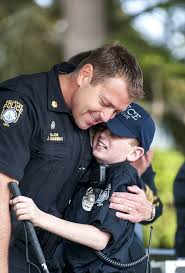

In [ ]:
image_path = '/content/'

from IPython.display import Image

image_check = 'goodcop.jpg'

Image(image_path+image_check)

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

/content/goodcop.jpg
Input image shape: (1, 300, 300, 3)


In [ ]:
preds = model_2.predict(x)
print('Predicted:', preds)

Predicted: [[0.00822057 0.9917794 ]]


In [ ]:
result = preds[0][0]
if result < preds[0][1]:
  print("Good cop")
else:
  print("Bad Cop No Doughnut")

Good cop


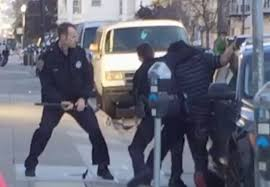

In [ ]:
image_check = 'badcop.jpg'

Image(image_path+image_check)

In [ ]:
img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model_2.predict(x)
print('Predicted:', preds)

/content/badcop.jpg
Predicted: [[9.9999893e-01 1.0625163e-06]]


In [ ]:
if result < preds[0][1]:
  print("Good cop")
else:
  print("Bad Cop No Doughnut")

Bad Cop No Doughnut


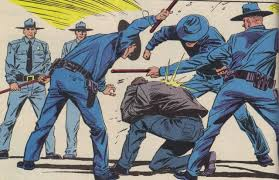

In [ ]:
image_check = 'badcop2.jpg'

Image(image_path+image_check)



In [ ]:
img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model_2.predict(x)
print('Predicted:', preds)


if result < preds[0][1]:
  print("Good cop")
else:
  print("Bad Cop No Doughnut")

/content/badcop2.jpg
Predicted: [[9.993569e-01 6.430212e-04]]
Bad Cop No Doughnut


This model is kinda lit!